## 8. 选股_投资广度 
从tushare到Alphalens到rqalpha 

In [1]:
import talib as ta
import numpy as np

# 1. 编制函数需要的算法，调用talib计算momentum
def momentum(df, period=2):
    return pd.DataFrame(
        {name: ta.ROCR(item.values, period) 
         for name, item in df.iteritems()},
         index=df.index
        )

# 2. 定义计算alpha值的类
class alphas(object):
    def __init__(self, pn_data):
        if pn_data.isnull().values.any():
            pn_data.fillna(method='ffill',inplace=True)
        self.close = pd.DataFrame(pn_data.minor_xs('close'), 
                                  dtype=np.float64)

# 3. 编制因子的函数，并返回因子DataFrame
    def mom001(self):
        alpha = -1 * momentum(self.close)
        return alpha

In [2]:
# 4. 传入股票数据
if __name__ == '__main__':
    import pandas as pd
    import tushare as ts

    codes = ['000001', '601318', '600029', '000089', '000402', 
             '000895', '600006', '000858', '600036', '600050']
    stocks_dict = {}
    for c in codes:
        stock = ts.get_k_data(c, start='2013-01-01', end='2016-12-31', ktype='D', autype='qfq')
        stock.index = pd.to_datetime(stock['date'], format='%Y-%m-%d')
        stock.pop('date')
        stocks_dict[c] = stock

    pn = pd.Panel(stocks_dict)
    print pn

<class 'pandas.core.panel.Panel'>
Dimensions: 10 (items) x 971 (major_axis) x 6 (minor_axis)
Items axis: 000001 to 601318
Major_axis axis: 2013-01-04 00:00:00 to 2016-12-30 00:00:00
Minor_axis axis: open to code


In [3]:
#5. 输出Factor数据
alpha_mom = alphas(pn).mom001()
print alpha_mom.tail()

              000001    000089    000402    000858    000895    600006  \
date                                                                     
2016-12-26 -0.997812 -0.993865 -1.025000 -0.970079 -0.983686 -0.980716   
2016-12-27 -1.000000 -1.004957 -1.021236 -0.997687 -0.999486 -0.988764   
2016-12-28 -0.993421 -0.983951 -0.978424 -0.987193 -0.995092 -0.973315   
2016-12-29 -1.000000 -0.974106 -0.977316 -0.985733 -1.005353 -0.982955   
2016-12-30 -1.004415 -1.003764 -0.987536 -1.016796 -1.026532 -0.992785   

              600029    600036    600050    601318  
date                                                
2016-12-26 -0.988811 -1.001693 -1.016927 -1.010066  
2016-12-27 -0.985975 -1.006250 -0.966709 -1.015261  
2016-12-28 -0.985856 -0.992676 -0.984635 -1.004841  
2016-12-29 -0.994310 -0.987578 -0.998675 -0.996313  
2016-12-30 -1.007174 -0.998865 -0.950585 -1.003967  


In [4]:
#转换成MultiIndex
factor = alpha_mom.stack()
print factor.tail()

date              
2016-12-30  600006   -0.992785
            600029   -1.007174
            600036   -0.998865
            600050   -0.950585
            601318   -1.003967
dtype: float64


In [5]:
# 股票池价格的Dataframe
prices = pn.minor_xs('close')
print prices.tail()

           000001 000089 000402  000858  000895 600006 600029 600036 600050  \
date                                                                          
2016-12-26   9.12    8.1  10.66  33.653  19.355   7.12   7.07  17.75   7.81   
2016-12-27   9.08   8.11  10.58  33.643   19.43   7.04   7.03  17.71   7.55   
2016-12-28   9.06   7.97  10.43  33.222   19.26   6.93   6.97  17.62   7.69   
2016-12-29   9.08    7.9  10.34  33.163  19.534   6.92   6.99  17.49   7.54   
2016-12-30    9.1      8   10.3   33.78  19.771   6.88   7.02   17.6   7.31   

           601318  
date               
2016-12-26  35.12  
2016-12-27  35.26  
2016-12-28  35.29  
2016-12-29  35.13  
2016-12-30  35.43  


In [6]:
#输入Alphalen所需要的数据格式
import alphalens

factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor, prices, quantiles=5)
print factor_data.head()

                          1         5        10    factor  factor_quantile
date       asset                                                          
2013-01-08 000001 -0.008869  0.100633  0.280000 -1.000725                3
           000089 -0.002677  0.018201  0.065043 -1.000000                3
           000402 -0.005838  0.001501  0.007339 -0.989764                4
           000858  0.017792  0.014242 -0.062885 -1.008229                1
           000895 -0.000809  0.049779  0.044055 -1.076495                1


In [7]:
cond = factor_data['factor_quantile'] == 1
save = factor_data[cond]
s = pd.Series(True, index=save.index)
s = s.unstack()
s[s != True] = False
print(s)

asset      000001 000089 000402 000858 000895 600006 600029 600036 600050  \
date                                                                        
2013-01-08  False  False  False   True   True  False  False  False  False   
2013-01-09  False  False  False   True   True  False  False  False  False   
2013-01-10  False  False  False   True  False  False   True  False  False   
2013-01-11  False  False  False   True  False  False   True  False  False   
2013-01-14   True  False  False  False   True  False  False  False  False   
2013-01-15   True  False  False  False  False  False  False  False  False   
2013-01-16   True  False  False  False   True  False  False  False  False   
2013-01-17  False   True  False  False   True  False  False  False  False   
2013-01-18  False   True   True  False  False  False  False  False  False   
2013-01-21   True  False  False  False  False  False   True  False  False   
2013-01-22   True  False  False  False  False  False  False   True  False   

## 2. 得出表格后转名字并用到rqalpha测试

In [8]:
def coder(code):
    if code.startswith('6'):
        return code + '.XSHG'
    elif code.startswith('3') or code.startswith('0'):
        return code + '.XSHE'
    else:
        return code

codes = s.columns
new_codes = []
for code in codes:
    c = coder(code)
    new_codes.append(c)

s.columns = new_codes
print s
s.to_csv('C:\\Users\\small\\Desktop\\alpha_stocks.csv')

           000001.XSHE 000089.XSHE 000402.XSHE 000858.XSHE 000895.XSHE  \
date                                                                     
2013-01-08       False       False       False        True        True   
2013-01-09       False       False       False        True        True   
2013-01-10       False       False       False        True       False   
2013-01-11       False       False       False        True       False   
2013-01-14        True       False       False       False        True   
2013-01-15        True       False       False       False       False   
2013-01-16        True       False       False       False        True   
2013-01-17       False        True       False       False        True   
2013-01-18       False        True        True       False       False   
2013-01-21        True       False       False       False       False   
2013-01-22        True       False       False       False       False   
2013-01-23       False       False    

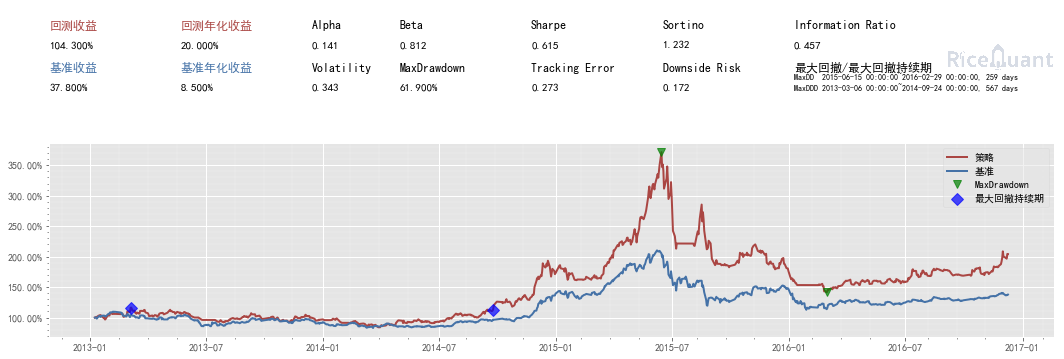

{'sys_analyser': {'benchmark_portfolio':                cash  market_value  static_unit_net_value  total_value  \
  date                                                                    
  2013-01-08  1512.13      98487.87                  1.000    100000.00   
  2013-01-09  1512.13      98519.07                  1.000    100031.20   
  2013-01-10  1512.13      98692.23                  1.000    100204.36   
  2013-01-11  1512.13      96845.97                  1.002     98358.10   
  2013-01-14  1512.13     100531.08                  0.984    102043.21   
  2013-01-15  1512.13     101238.54                  1.020    102750.67   
  2013-01-16  1512.13     100506.51                  1.028    102018.64   
  2013-01-17  1512.13      99557.64                  1.020    101069.77   
  2013-01-18  1512.13     101222.16                  1.011    102734.29   
  2013-01-21  1512.13     101825.10                  1.027    103337.23   
  2013-01-22  1512.13     101279.10                  1.033   

In [2]:
#coding=utf-8
# run_code_demo
from rqalpha import run_code

code = """

import numpy as np
import talib as ta
import pandas as pd
import os
import rqalpha
from rqalpha.api import *


def init(context):
    from datetime import timedelta
    codes = pd.read_excel('C:/Users/small/Desktop/alpha.xlsx')
    codes.index = codes.pop('date') + timedelta(hours=15)
    context.codes = codes

def find_pool(context, date):
    codes = context.codes.loc[date]
    return codes.index[codes == True]

def handle_bar(context, bar_dict):
    pool = find_pool(context, context.now)
    print context.now
    sell(context)
    result = []
    for codes in pool:
        data_c = history_bars(codes, 25, '1d', 'close')
        ma = ta.MA(data_c, timeperiod=20)
        if ma[-1] > ma[-2] and ma[-2] > ma[-3]:
            result.append(codes)
    # print result
    if len(result):
        print result
        for r in result:
            order_target_percent(r, 0.5)


def sell(context):
    sell_list = []
    for stocks in context.portfolio.positions:
        data_c = history_bars(stocks, 25, '1d', 'close')
        ma = ta.MA(data_c, timeperiod=20)
        if ma[-1] < ma[-2] and ma[-2] < ma[-3]:
            sell_list.append(stocks)
    print('sell_list:', sell_list)
    if len(sell_list):
        for s in sell_list:
            order_target_percent(s, 0)

"""

config = {
  "base": {
    "start_date": "2013-01-08",
    "end_date": "2016-12-11",
    "securities": ['stock'],
    "stock_starting_cash": 100000,
    "benchmark": "000300.XSHG"
#     "strategy_file_path": os.path.abspath(__file__)
  },
  "extra": {
    "log_level": "verbose",
  },
  "mod": {
    "sys_analyser": {
      "enabled": True,
      "plot": True
    }
  }
}

# 您可以指定您要传递的参数
run_code(code, config)
